# UTAG Tutorial

This notebook is a how-to tutorial for the UTAG software for users new to either scanpy or UTAG.

In [1]:
from utag import utag
import scanpy as sc
import squidpy as sq
import anndata
import numpy as np
import matplotlib.pyplot as plt

## Downloading / Opening data for input

In [2]:
# Open / Download data for UTAG
adata = sc.read(
    'data/healthy_lung_adata.h5ad',
    backup_url='https://zenodo.org/record/6376767/files/healthy_lung_adata.h5ad?download=1'
)

display(adata)
print(f"\nThis AnnData Object contains {adata.X.shape[0]} cells and {adata.X.shape[1]} markers across {adata.obs['roi'].nunique()} ROIs.")

AnnData object with n_obs × n_vars = 71946 × 33
    obs: 'sample', 'obj_id', 'X_centroid', 'Y_centroid', 'roi', 'Diseased State', 'Age', 'Patient', 'Image Location', 'cell type', 'slide', 'topological_domain', 'id', 'domain', 'UTAG Label'
    var: 'mean', 'std'
    uns: 'UTAG Label_colors', 'cell type_colors', 'cell_type_colors', 'domain_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


This AnnData Object contains 71946 cells and 33 markers across 26 ROIs.


### Understanding UTAG input data

The input for UTAG is an `AnnData` object which follows the format below.

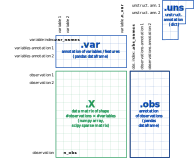

In [3]:
from IPython.display import SVG
display(SVG(url='https://falexwolf.de/img/scanpy/anndata.svg'))

#### Constructing bare minimal AnnData input for UTAG

In [4]:
obs = adata.obs[['roi', 'X_centroid', 'Y_centroid']]
X = adata.X
var = adata.var

minimal_adata = anndata.AnnData(
    X = np.array(X).astype(np.float64),
    obs = obs,
    var = var
)

minimal_adata.obsm['spatial'] = np.array(minimal_adata.obs[['Y_centroid', 'X_centroid']])

del minimal_adata.var['mean']
del minimal_adata.var['std']
del minimal_adata.obs['Y_centroid']
del minimal_adata.obs['X_centroid']

minimal_adata

AnnData object with n_obs × n_vars = 71946 × 33
    obs: 'roi'
    obsm: 'spatial'

We will later use the `minimal_adata` as an input to UTAG. Input to UTAG <b>MUST</b> include: `slide_key`, a unique identifier for each images stored in `obs` layer, and `'spatial'` key in `obsm` layer as `(Y,X)` coordinates. 

#### Understanding AnnData

This section is for readers new to `AnnData` structure. Feel free to skip ahead to the next section if you are familiar with the data structure.

`adata.X` layer <b>MUST</b> includes cellular feature values as `numpy.ndarray` of numeric values such as `float64`.

In [5]:
adata.X[:10,:5]

array([[-1.70645487,  0.2373627 , -2.28904053, -0.50029525, -1.70298401],
       [-1.08716941,  0.08932389, -1.28257402, -0.66850611, -1.15434735],
       [ 0.22667865,  1.90141001, -1.34062691, -0.75262479, -1.07385927],
       [ 1.00571368, -0.53482487, -1.60467477, -0.55293174, -0.56142126],
       [ 1.08540701,  0.53941144,  1.18953333, -0.08396093,  0.28295329],
       [-0.45666285,  0.56307371,  1.68868451, -0.56456302,  1.11549262],
       [ 1.2244919 ,  0.26945719,  0.68697793, -0.44335321,  1.6149787 ],
       [ 1.15205047,  0.05833878, -0.2478962 , -0.53878253, -0.84522345],
       [ 0.76803306,  1.23442798,  0.05075282, -0.58354001,  0.65071288],
       [ 0.63119791, -0.18546919, -1.46099517, -0.53468439,  0.27747703]])

`adata.obsm['spatial']` <b>MUST</b> include cell `x` and `y` coordinates as a 2D `numpy.ndarray` for UTAG to run.

In [6]:
display(adata.obsm['spatial'])

print(f"\nData type: {type(adata.obsm['spatial'])}")
print(f"Element type: {adata.obsm['spatial'].dtype}")

array([[709.42307692,   3.        ],
       [608.69047619,   4.85714286],
       [677.39473684,   5.5       ],
       ...,
       [ 36.73611111, 675.59722222],
       [135.33139535, 676.20348837],
       [376.12244898, 677.83673469]])


Data type: <class 'numpy.ndarray'>
Element type: float64


`adata.obs` layer is a `pandas.DataFrame` object that includes numeric and non-numeric features associated with each cell such as cell type labels, annotated domains, and this is also where UTAG results are stored after the function is ran.

In [7]:
adata.obs.head()

,sample,obj_id,X_centroid,Y_centroid,roi,Diseased State,Age,Patient,Image Location,cell type,slide,topological_domain,id,domain,UTAG Label
0,UNC_59,19,3.000000,709.423077,UNC_59-01,Healthy,Younger,UNC_59,distal,Connective,IMC_0,V,UNC_59-01_19,Vessel,Airway wall
1,UNC_59,23,4.857143,608.690476,UNC_59-01,Healthy,Younger,UNC_59,distal,Connective,IMC_0,V,UNC_59-01_23,Vessel,Airway wall
2,UNC_59,25,5.500000,677.394737,UNC_59-01,Healthy,Younger,UNC_59,distal,Endothelial,IMC_0,V,UNC_59-01_25,Vessel,Vessel
3,UNC_59,26,4.900000,539.780000,UNC_59-01,Healthy,Younger,UNC_59,distal,Endothelial,IMC_0,AR,UNC_59-01_26,Alveolar space,Alveolar space
4,UNC_59,27,5.060345,90.517241,UNC_59-01,Healthy,Younger,UNC_59,distal,CD8 T cells,IMC_0,AR,UNC_59-01_27,Alveolar space,Alveolar space


`adata.var` layer includes features associated with each columns of `adata.X`.

In [8]:
adata.var.head()

,mean,std
AQP1,-0.000061,0.721804
aSMA,-0.004072,0.911866
BTUBB4,-0.006200,0.807557
CC16,-0.030729,0.681301
CCL19,-0.000283,0.743562


### Visualizing sample ROIs

In [9]:
def visualize_rois(adata, n_rois = 3, roi_key = 'roi', color_key = 'cell type', dpi = 300):
    # increase dpi for a more crisp visualization
    fig, axes = plt.subplots(1, n_rois, figsize = (n_rois * 3 + 1,3), dpi = 100)

    for i, roi in enumerate(adata.obs[roi_key].unique()[:n_rois]):
        a = adata[adata.obs[roi_key] == roi].copy()

        if i == n_rois - 1:
            sc.pl.spatial(a, color = color_key, spot_size = 10, ax = axes[i], title = '', frameon = False, show = False)
        else:
            sc.pl.spatial(a, color = color_key, spot_size = 10, ax = axes[i], title = '', frameon = False, legend_loc = 'none', show = False)
    plt.tight_layout()
    plt.show()

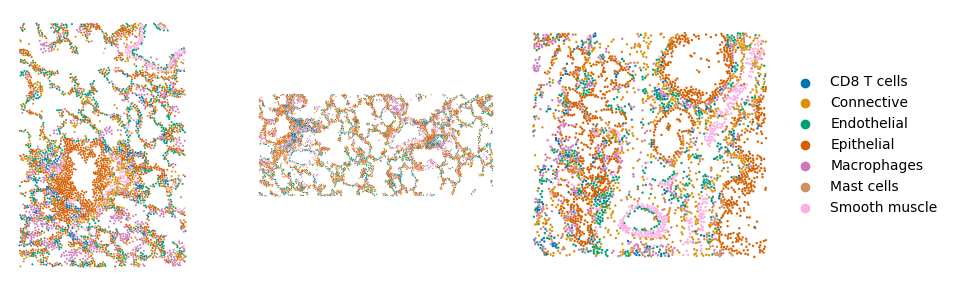

In [10]:
# increase dpi for a more crisp visualization
visualize_rois(adata, dpi = 100)

In [11]:
### Side tutorial on visualizing spatial graph

In [12]:
slide = adata[adata.obs['roi'] == adata.obs['roi'].unique()[2]].copy()
sq.gr.spatial_neighbors(slide, coord_type = 'generic', radius = 15)
slide

AnnData object with n_obs × n_vars = 3791 × 33
    obs: 'sample', 'obj_id', 'X_centroid', 'Y_centroid', 'roi', 'Diseased State', 'Age', 'Patient', 'Image Location', 'cell type', 'slide', 'topological_domain', 'id', 'domain', 'UTAG Label'
    var: 'mean', 'std'
    uns: 'UTAG Label_colors', 'cell type_colors', 'cell_type_colors', 'domain_colors', 'neighbors', 'pca', 'umap', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

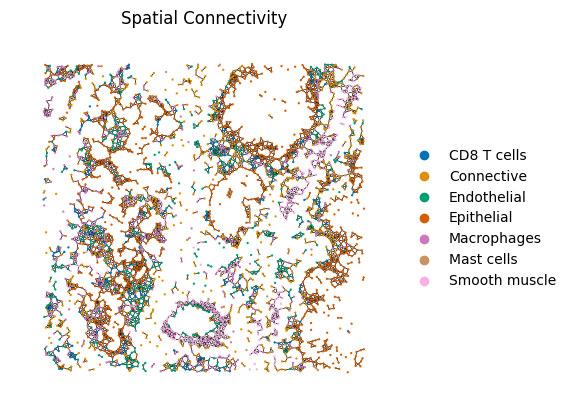

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (5,5), dpi = 100)
sc.pl.spatial(slide, color = 'cell type', spot_size = 7, ax = ax, title = 'Spatial Connectivity', frameon = False, edges = True, neighbors_key = 'spatial_neighbors', edges_width = 0.5, edges_color = 'black')

## Running UTAG in batch mode

In [ ]:
%%time
# Run UTAG on provided data
utag_results = utag(
    minimal_adata,
    slide_key="roi",
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [0.3]
)

utag_results

Applying UTAG Algorithm...


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

Applying Leiden Clustering at Resolution: 0.3...


### Visualizing UTAG results

In [ ]:
# increase dpi for a more crisp visualization
visualize_rois(utag_results, color_key = 'UTAG Label_leiden_0.3', dpi = 100)

## Running UTAG on single slide

In [ ]:
%%time

single_slide = minimal_adata[minimal_adata.obs['roi'] == minimal_adata.obs['roi'].unique()[2]].copy()
display(single_slide)
# Run UTAG on provided data
utag_single_results = utag(
    single_slide,
    slide_key="roi",
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [0.3]
)

utag_single_results

In [ ]:
# increase dpi for a more crisp visualization
sc.pl.spatial(utag_single_results, color = 'UTAG Label_leiden_0.3', spot_size = 10, title = '', frameon = False)